**Overview**

The objective of this competition on Kaggle is to use various factors to predict the risk of obesity in individuals, which is related to cardiovascular diseases.

I performed EDA, pre-processing and applied just one predictive model, Random Forest, with some hyperparameters to seek its best predictive performance.

Random Forest is a supervised learning algorithm in Machine Learning, in short, it will create many decision trees, randomly, forming what we can visualize as a forest, and each tree will be used to define the final result, in a kind of voting.

Reference:
https://didatica.tech/o-que-e-e-como-funciona-o-algorithmo-randomforest/

<div align='left'>
    <img src="https://media.nutrition.org/wp-content/uploads/2017/08/nhs-cover_se.jpg">
</div>

# <div style= "font-family: serif; font-weight:bold; letter-spacing: 0px; color:white; font-size:70%; text-align:left;padding:3.0px; background: orange; border-bottom: 6px solid darkred"> 1. IMPORTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler,  LabelEncoder
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

import warnings as ww
ww.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


# <div style= "font-family: serif; font-weight:bold; letter-spacing: 0px; color:white; font-size:70%; text-align:left;padding:3.0px; background: orange; border-bottom: 6px solid darkred"> 2. LOAD DATA

In [2]:
train  = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test  = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

# <div style= "font-family: serif; font-weight:bold; letter-spacing: 0px; color:white; font-size:70%; text-align:left;padding:3.0px; background: orange; border-bottom: 6px solid darkred"> 3. EXPLORY DATA ANALYSIS

In [3]:
print(f'train shape: {train.shape}')
print(f'train duplicated: {train.duplicated().sum()}')

train shape: (20758, 18)
train duplicated: 0


In [4]:
train.sample(3)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
17248,17248,Male,22.889099,1.699793,95.324282,yes,yes,2.0,3.000000,Sometimes,no,2.000000,no,0.651412,1.00000,no,Public_Transportation,Obesity_Type_I
282,282,Female,19.337404,1.672310,49.660995,no,yes,2.0,4.000000,Sometimes,no,1.157395,no,2.000000,1.00000,Sometimes,Public_Transportation,Insufficient_Weight
20409,20409,Male,23.000000,1.719342,80.091886,yes,yes,3.0,2.669766,Sometimes,no,2.000000,no,1.668961,1.89388,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
train.dtypes

id                                  int64
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

In [6]:
def Binaryzer(x):
	binaryzer = {'yes': 1, 'no': 0}
	colums_to_replace= ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
	x[colums_to_replace] = x[colums_to_replace].replace(binaryzer)

In [7]:
Binaryzer(train)
Binaryzer(test)

In [8]:
train.select_dtypes(include='object').describe()

,Gender,CAEC,CALC,MTRANS,NObeyesdad
count,20758,20758,20758,20758,20758
unique,2,4,3,5,7
top,Female,Sometimes,Sometimes,Public_Transportation,Obesity_Type_III
freq,10422,17529,15066,16687,4046


In [9]:
categorical = ['Gender','CAEC','CALC','MTRANS','NObeyesdad']
numerical = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']

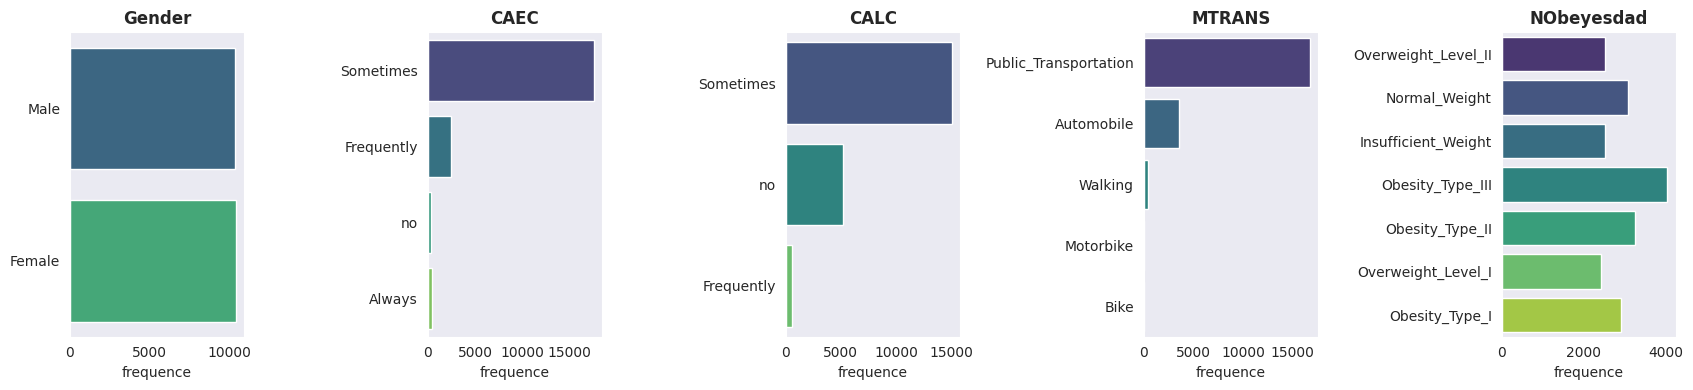

In [10]:
sns.set_style('dark')
plt.figure(figsize=(17,4))
for col in range(0, len(categorical)):
	plt.subplot(1,5,col+1)
	sns.countplot(train, y=categorical[col], palette='viridis')
	plt.ylabel('')
	plt.xlabel('frequence')
	plt.title(categorical[col], weight='bold')
plt.tight_layout()

In [11]:
train.select_dtypes(exclude='object').describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
id,20758.0,10378.50,5992.46,0.00,5189.25,10378.50,15567.75,20757.00
Age,20758.0,23.84,5.69,14.00,20.00,22.82,26.00,61.00
Height,20758.0,1.70,0.09,1.45,1.63,1.70,1.76,1.98
Weight,20758.0,87.89,26.38,39.00,66.00,84.06,111.60,165.06
family_history_with_overweight,20758.0,0.82,0.38,0.00,1.00,1.00,1.00,1.00
FAVC,20758.0,0.91,0.28,0.00,1.00,1.00,1.00,1.00
FCVC,20758.0,2.45,0.53,1.00,2.00,2.39,3.00,3.00
NCP,20758.0,2.76,0.71,1.00,3.00,3.00,3.00,4.00
SMOKE,20758.0,0.01,0.11,0.00,0.00,0.00,0.00,1.00
CH2O,20758.0,2.03,0.61,1.00,1.79,2.00,2.55,3.00


In [12]:
from scipy import stats
no_outlier = np.array([True] * len(train))

for col in numerical:
	zscore = abs(stats.zscore(train[col]))
	no_outlier =  (zscore < 3) & no_outlier

In [13]:
no_outlier.value_counts()

True     20479
False      279
Name: count, dtype: int64

In [14]:
train = train[no_outlier==True]

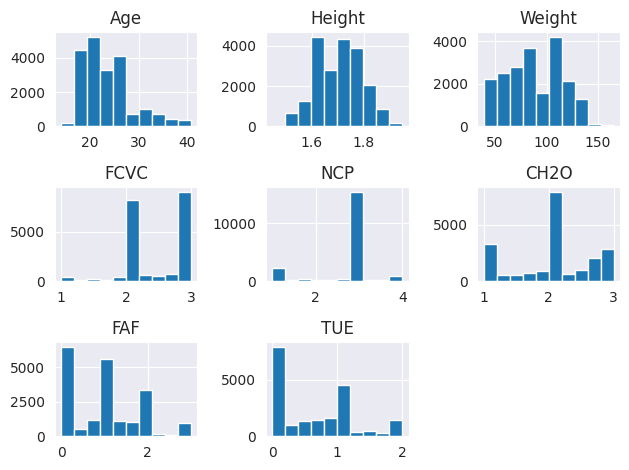

In [15]:
train[numerical].hist()
plt.tight_layout()

# <div style= "font-family: serif; font-weight:bold; letter-spacing: 0px; color:white; font-size:70%; text-align:left;padding:3.0px; background: orange; border-bottom: 6px solid darkred"> 4. PRE-PROCESS

In [16]:
train.sample(3)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
17818,17818,Male,26.947786,1.825449,120.399758,1,1,2.233720,3.0,Sometimes,0,2.715252,0,0.885633,0.939726,Sometimes,Public_Transportation,Obesity_Type_II
20704,20704,Male,17.894784,1.722884,97.971598,1,1,2.000000,3.0,Sometimes,0,3.000000,0,1.000000,2.000000,no,Public_Transportation,Obesity_Type_I
16270,16270,Male,17.085250,1.896073,59.258372,0,1,2.596364,4.0,Sometimes,0,2.000000,0,2.000000,1.000000,no,Automobile,Insufficient_Weight


In [17]:
def Encoder(x):
	encoder = LabelEncoder()
	to_encoder = ['Gender','CAEC','CALC','MTRANS']
	for col in to_encoder:
		x[col] = encoder.fit_transform(x[col]) 

In [18]:
Encoder(train)
Encoder(test)

In [19]:
Encoder_Target = LabelEncoder()
train['NObeyesdad'] = Encoder_Target.fit_transform(train['NObeyesdad'])
Encoder_Target.inverse_transform(train['NObeyesdad'])

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight', ...,
       'Obesity_Type_II', 'Overweight_Level_II', 'Obesity_Type_II'],
      dtype=object)

In [20]:
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

In [21]:
train.corr(numeric_only=True).style.background_gradient(cmap='Purples')

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
Gender,1.000000,0.077013,0.623288,0.116476,0.098264,0.023884,-0.316859,0.038122,0.047414,0.063480,0.049566,-0.062025,0.236206,0.056490,0.038924,-0.149956,0.043517
Age,0.077013,1.000000,0.016653,0.331638,0.279787,0.075390,0.054800,-0.049591,0.171856,0.059356,-0.000635,-0.115933,-0.205918,-0.292343,-0.101535,-0.579166,0.286987
Height,0.623288,0.016653,1.000000,0.416523,0.234027,0.118350,-0.076302,0.192351,0.069807,0.070146,0.180655,-0.098246,0.292576,0.069942,-0.086695,-0.068507,0.061422
Weight,0.116476,0.331638,0.416523,1.000000,0.517298,0.231351,0.246588,0.096381,0.339432,0.039892,0.319383,-0.185694,-0.086866,-0.089590,-0.218114,-0.013573,0.437533
family_history_with_overweight,0.098264,0.279787,0.234027,0.517298,1.000000,0.154160,0.050068,0.046801,0.205937,0.018248,0.195346,-0.167337,-0.092809,0.009705,0.000859,-0.104615,0.325005
FAVC,0.023884,0.075390,0.118350,0.231351,0.154160,1.000000,0.006980,0.011837,0.117108,-0.012478,0.041527,-0.112762,-0.066423,0.034461,-0.080726,-0.030707,0.013956
FCVC,-0.316859,0.054800,-0.076302,0.246588,0.050068,0.006980,1.000000,0.113884,-0.010738,-0.013070,0.101857,0.020700,-0.091712,-0.152530,-0.130044,0.088224,0.041753
NCP,0.038122,-0.049591,0.192351,0.096381,0.046801,0.011837,0.113884,1.000000,-0.089964,0.007116,0.082255,0.006074,0.101497,0.066190,-0.100695,-0.006084,-0.093327
CAEC,0.047414,0.171856,0.069807,0.339432,0.205937,0.117108,-0.010738,-0.089964,1.000000,-0.018965,0.135580,-0.099384,-0.091545,-0.049765,-0.070259,-0.052322,0.302512
SMOKE,0.063480,0.059356,0.070146,0.039892,0.018248,-0.012478,-0.013070,0.007116,-0.018965,1.000000,-0.023570,0.015227,0.008674,-0.016274,-0.022058,-0.021442,-0.001517


In [22]:
def Normalize(x, y):
	normalize = MinMaxScaler()
	to_normalize = ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']
	normalize.fit(x[to_normalize])
	x[to_normalize] = normalize.transform(x[to_normalize])
	y[to_normalize] = normalize.transform(y[to_normalize])

In [23]:
Normalize(train, test)

In [24]:
train.sample(3)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
1464,1.0,0.111851,0.804172,0.154692,0.0,1.0,0.5,0.666667,0.666667,0.0,0.500000,0.0,0.333333,0.500000,1.0,1.00,0
16064,0.0,0.186418,0.221147,0.095195,0.0,0.0,0.5,0.666667,0.666667,0.0,0.500000,0.0,0.000000,0.500000,0.5,0.75,1
6275,0.0,0.447402,0.386200,0.578523,1.0,1.0,1.0,0.666667,0.666667,0.0,0.787036,0.0,0.000000,0.047107,0.5,0.75,4


# <div style= "font-family: serif; font-weight:bold; letter-spacing: 0px; color:white; font-size:70%; text-align:left;padding:3.0px; background: orange; border-bottom: 6px solid darkred"> 5. SPLIT TRAIN AND TEST DATA

In [25]:
X = train.drop('NObeyesdad', axis=1)
Y = train['NObeyesdad']

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=.8, random_state=42)

In [27]:
y_train.value_counts() / y_train.value_counts().sum() * 100

NObeyesdad
4    19.770494
3    15.882317
1    15.039980
2    13.422450
0    12.378685
6    11.835439
5    11.670634
Name: count, dtype: float64

# <div style= "font-family: serif; font-weight:bold; letter-spacing: 0px; color:white; font-size:70%; text-align:left;padding:3.0px; background: orange; border-bottom: 6px solid darkred"> 6. TRAINING AND EVALUATION OF RANDOM FOREST MODEL

In [28]:
from scipy.stats import randint as sp_randint

In [29]:
param_dist = {
    'n_estimators': sp_randint(50, 200),
    'max_depth': [None] + list(sp_randint(10, 30).rvs(9)),
    'min_samples_split': sp_randint(2, 10),
    'min_samples_leaf': sp_randint(1, 4),
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [30]:
model_v1 = RandomForestClassifier()

In [31]:
random_search = RandomizedSearchCV(estimator=model_v1, 
								   param_distributions=param_dist, 
								   n_iter=20, 
								   cv=5, 
								   scoring='accuracy', 
								   random_state=42)

In [32]:
random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 14, 10, 10, 28, 23,
                                                      26, 24, 11, 17],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bac92c47460>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bac92c471f0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bac92c475b0>},
                   random_state=42, scoring='accuracy')

In [33]:
best_params = random_search.best_params_
print("Best params:", best_params)

Best params: {'criterion': 'gini', 'max_depth': 26, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 185}


In [34]:
y_pred = random_search.predict(x_test)

In [35]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.89794921875


In [36]:
y_pred_sub = random_search.predict(test)

In [37]:
y_pred_sub = Encoder_Target.inverse_transform(y_pred_sub)

In [38]:
test_Id  = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

In [39]:
output = pd.DataFrame({
	'id': test_Id['id'],
	'NObeyesdad': y_pred_sub})

In [40]:
#submission = output.to_csv('submission.csv', index=False)